## Define the Convolutional Neural Network

Once we know the shapes of the images and of the keypoints, we can define a convolutional neural network that can *learn* from this data.

1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

The above layers and add multiple convolutional layers and things like dropout layers that may prevent overfitting. [this paper](https://arxiv.org/pdf/1710.00977.pdf)


### Define the model in the `models.py` file


---

## PyTorch Neural Nets

Define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. 
During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
A conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### models.py

Defining the network in the `models.py` file so that any models defined can be saved and loaded by name in this project directory. For example, by defining a CNN class called `Net` in `models.py`, we can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if not exists;
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-04-09 15:08:44--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.15.14
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.15.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  84.3MB/s    in 4.1s    

2020-04-09 15:08:48 (79.2 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you

from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc1_drop): Dropout(p=0.15)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc2_drop): Dropout(p=0.25)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset created is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms defined are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.


In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. we could see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that we can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how the model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, the  follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging 

If we get a size or dimension error here, make sure that the network outputs the expected number of keypoints! Or if we get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints



In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation



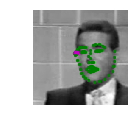

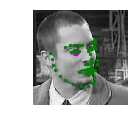

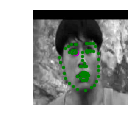

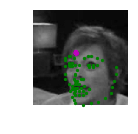

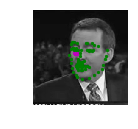

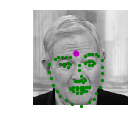

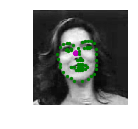

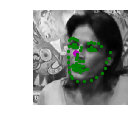

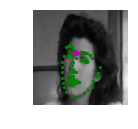

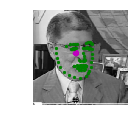

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, we want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### Define the loss and optimization

Next, define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## Define the loss and optimization
import torch.optim as optim

#criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr= 0.001)


## Training and Initial Observation



In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [15]:
# train your network
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.2718676269054413
Epoch: 1, Batch: 20, Avg. Loss: 0.13427106738090516
Epoch: 1, Batch: 30, Avg. Loss: 0.11297264508903027
Epoch: 1, Batch: 40, Avg. Loss: 0.11241017282009125
Epoch: 1, Batch: 50, Avg. Loss: 0.10061709210276604
Epoch: 1, Batch: 60, Avg. Loss: 0.09764219969511032
Epoch: 1, Batch: 70, Avg. Loss: 0.10535869151353836
Epoch: 1, Batch: 80, Avg. Loss: 0.11975046806037426
Epoch: 1, Batch: 90, Avg. Loss: 0.11785138100385666
Epoch: 1, Batch: 100, Avg. Loss: 0.07820100523531437
Epoch: 1, Batch: 110, Avg. Loss: 0.09766938313841819
Epoch: 1, Batch: 120, Avg. Loss: 0.09209658727049827
Epoch: 1, Batch: 130, Avg. Loss: 0.11841143928468227
Epoch: 1, Batch: 140, Avg. Loss: 0.0884278405457735
Epoch: 1, Batch: 150, Avg. Loss: 0.087070769444108
Epoch: 1, Batch: 160, Avg. Loss: 0.09519827887415885
Epoch: 1, Batch: 170, Avg. Loss: 0.09237399473786354
Epoch: 1, Batch: 180, Avg. Loss: 0.08256174810230732
Epoch: 1, Batch: 190, Avg. Loss: 0.09963132292032242
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.10586014837026596
Epoch: 2, Batch: 20, Avg. Loss: 0.0906455997377634
Epoch: 2, Batch: 30, Avg. Loss: 0.11238327100872994
Epoch: 2, Batch: 40, Avg. Loss: 0.08301969096064568
Epoch: 2, Batch: 50, Avg. Loss: 0.0713262639939785
Epoch: 2, Batch: 60, Avg. Loss: 0.08964365012943745
Epoch: 2, Batch: 70, Avg. Loss: 0.10586374327540397
Epoch: 2, Batch: 80, Avg. Loss: 0.0840003877878189
Epoch: 2, Batch: 90, Avg. Loss: 0.08098015412688256
Epoch: 2, Batch: 100, Avg. Loss: 0.09141461029648781
Epoch: 2, Batch: 110, Avg. Loss: 0.09078468941152096
Epoch: 2, Batch: 120, Avg. Loss: 0.11218789219856262
Epoch: 2, Batch: 130, Avg. Loss: 0.1081441305577755
Epoch: 2, Batch: 140, Avg. Loss: 0.07494553290307522
Epoch: 2, Batch: 150, Avg. Loss: 0.10912911668419838
Epoch: 2, Batch: 160, Avg. Loss: 0.0825595200061798
Epoch: 2, Batch: 170, Avg. Loss: 0.08887149170041084
Epoch: 2, Batch: 180, Avg. Loss: 0.08567712791264057
Epoch: 2, Batch: 190, Avg. Loss: 0.08416704647243023
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.09484198428690434
Epoch: 3, Batch: 20, Avg. Loss: 0.0763839352875948
Epoch: 3, Batch: 30, Avg. Loss: 0.09320503622293472
Epoch: 3, Batch: 40, Avg. Loss: 0.07924904264509677
Epoch: 3, Batch: 50, Avg. Loss: 0.0638437144458294
Epoch: 3, Batch: 60, Avg. Loss: 0.07700476013123989
Epoch: 3, Batch: 70, Avg. Loss: 0.0938433788716793
Epoch: 3, Batch: 80, Avg. Loss: 0.10908860638737679
Epoch: 3, Batch: 90, Avg. Loss: 0.07755707241594792
Epoch: 3, Batch: 100, Avg. Loss: 0.06969042755663395
Epoch: 3, Batch: 110, Avg. Loss: 0.07506903819739819
Epoch: 3, Batch: 120, Avg. Loss: 0.09359176568686962
Epoch: 3, Batch: 130, Avg. Loss: 0.07221797332167626
Epoch: 3, Batch: 140, Avg. Loss: 0.07401909083127975
Epoch: 3, Batch: 150, Avg. Loss: 0.08512388803064823
Epoch: 3, Batch: 160, Avg. Loss: 0.07201168201863765
Epoch: 3, Batch: 170, Avg. Loss: 0.08131553828716279
Epoch: 3, Batch: 180, Avg. Loss: 0.07533853426575661
Epoch: 3, Batch: 190, Avg. Loss: 0.06082755345851183
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.0630215410143137
Epoch: 4, Batch: 20, Avg. Loss: 0.0764521311968565
Epoch: 4, Batch: 30, Avg. Loss: 0.04754118025302887
Epoch: 4, Batch: 40, Avg. Loss: 0.057979359105229375
Epoch: 4, Batch: 50, Avg. Loss: 0.05798913799226284
Epoch: 4, Batch: 60, Avg. Loss: 0.06852193437516689
Epoch: 4, Batch: 70, Avg. Loss: 0.05212622508406639
Epoch: 4, Batch: 80, Avg. Loss: 0.05288824662566185
Epoch: 4, Batch: 90, Avg. Loss: 0.05440466273576021
Epoch: 4, Batch: 100, Avg. Loss: 0.04505680818110704
Epoch: 4, Batch: 110, Avg. Loss: 0.049351852759718894
Epoch: 4, Batch: 120, Avg. Loss: 0.04629929773509502
Epoch: 4, Batch: 130, Avg. Loss: 0.05502074845135212
Epoch: 4, Batch: 140, Avg. Loss: 0.04845657255500555
Epoch: 4, Batch: 150, Avg. Loss: 0.049073484539985654
Epoch: 4, Batch: 160, Avg. Loss: 0.051514909416437146
Epoch: 4, Batch: 170, Avg. Loss: 0.04447324238717556
Epoch: 4, Batch: 180, Avg. Loss: 0.04402825031429529
Epoch: 4, Batch: 190, Avg. Loss: 0.0356173874810338
E

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.032634511776268485
Epoch: 5, Batch: 20, Avg. Loss: 0.03280007783323526
Epoch: 5, Batch: 30, Avg. Loss: 0.060236850567162034
Epoch: 5, Batch: 40, Avg. Loss: 0.03312959298491478
Epoch: 5, Batch: 50, Avg. Loss: 0.04738805666565895
Epoch: 5, Batch: 60, Avg. Loss: 0.04453587885946035
Epoch: 5, Batch: 70, Avg. Loss: 0.03989976346492767
Epoch: 5, Batch: 80, Avg. Loss: 0.03043516632169485
Epoch: 5, Batch: 90, Avg. Loss: 0.03698891829699278
Epoch: 5, Batch: 100, Avg. Loss: 0.033759085647761825
Epoch: 5, Batch: 110, Avg. Loss: 0.03562004808336496
Epoch: 5, Batch: 120, Avg. Loss: 0.03225885946303606
Epoch: 5, Batch: 130, Avg. Loss: 0.03066406035795808
Epoch: 5, Batch: 140, Avg. Loss: 0.032879763282835484
Epoch: 5, Batch: 150, Avg. Loss: 0.03563412744551897
Epoch: 5, Batch: 160, Avg. Loss: 0.03330851923674345
Epoch: 5, Batch: 170, Avg. Loss: 0.03392482493072748
Epoch: 5, Batch: 180, Avg. Loss: 0.031522159837186335
Epoch: 5, Batch: 190, Avg. Loss: 0.057002687826752

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.031070064380764963
Epoch: 6, Batch: 20, Avg. Loss: 0.02502600532025099
Epoch: 6, Batch: 30, Avg. Loss: 0.02513618068769574
Epoch: 6, Batch: 40, Avg. Loss: 0.024643796682357787
Epoch: 6, Batch: 50, Avg. Loss: 0.0268936138600111
Epoch: 6, Batch: 60, Avg. Loss: 0.02955326121300459
Epoch: 6, Batch: 70, Avg. Loss: 0.03330431040376425
Epoch: 6, Batch: 80, Avg. Loss: 0.02224990203976631
Epoch: 6, Batch: 90, Avg. Loss: 0.02475644089281559
Epoch: 6, Batch: 100, Avg. Loss: 0.027662858180701733
Epoch: 6, Batch: 110, Avg. Loss: 0.03062151577323675
Epoch: 6, Batch: 120, Avg. Loss: 0.02407732969149947
Epoch: 6, Batch: 130, Avg. Loss: 0.02950929570943117
Epoch: 6, Batch: 140, Avg. Loss: 0.03883684054017067
Epoch: 6, Batch: 150, Avg. Loss: 0.038006614334881304
Epoch: 6, Batch: 160, Avg. Loss: 0.029996697045862674
Epoch: 6, Batch: 170, Avg. Loss: 0.021336330194026233
Epoch: 6, Batch: 180, Avg. Loss: 0.03852742034941912
Epoch: 6, Batch: 190, Avg. Loss: 0.026969556137919

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.022824123222380876
Epoch: 7, Batch: 20, Avg. Loss: 0.020239118486642838
Epoch: 7, Batch: 30, Avg. Loss: 0.021352306008338928
Epoch: 7, Batch: 40, Avg. Loss: 0.029530429374426605
Epoch: 7, Batch: 60, Avg. Loss: 0.03845193162560463
Epoch: 7, Batch: 70, Avg. Loss: 0.026833615079522134
Epoch: 7, Batch: 80, Avg. Loss: 0.022353664692491292
Epoch: 7, Batch: 90, Avg. Loss: 0.025178397260606288
Epoch: 7, Batch: 100, Avg. Loss: 0.029370669927448034
Epoch: 7, Batch: 110, Avg. Loss: 0.023190201446413993
Epoch: 7, Batch: 120, Avg. Loss: 0.03228785675019026
Epoch: 7, Batch: 130, Avg. Loss: 0.0226421439088881
Epoch: 7, Batch: 140, Avg. Loss: 0.020091602858155966
Epoch: 7, Batch: 150, Avg. Loss: 0.027743347361683844
Epoch: 7, Batch: 160, Avg. Loss: 0.026121966168284418
Epoch: 7, Batch: 170, Avg. Loss: 0.01946649020537734
Epoch: 7, Batch: 180, Avg. Loss: 0.03775966027751565
Epoch: 7, Batch: 190, Avg. Loss: 0.017476966325193643
Epoch: 7, Batch: 200, Avg. Loss: 0.0310655

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.021808093693107367
Epoch: 8, Batch: 20, Avg. Loss: 0.0375108702108264
Epoch: 8, Batch: 30, Avg. Loss: 0.0218458010815084
Epoch: 8, Batch: 40, Avg. Loss: 0.020906456653028725
Epoch: 8, Batch: 50, Avg. Loss: 0.02317863265052438
Epoch: 8, Batch: 60, Avg. Loss: 0.018443605210632086
Epoch: 8, Batch: 70, Avg. Loss: 0.028118946030735968
Epoch: 8, Batch: 80, Avg. Loss: 0.020037044119089843
Epoch: 8, Batch: 90, Avg. Loss: 0.02161954212933779
Epoch: 8, Batch: 100, Avg. Loss: 0.026121047604829074
Epoch: 8, Batch: 110, Avg. Loss: 0.022937480825930834
Epoch: 8, Batch: 120, Avg. Loss: 0.04047356983646751
Epoch: 8, Batch: 130, Avg. Loss: 0.021926029585301876
Epoch: 8, Batch: 140, Avg. Loss: 0.02020527133718133
Epoch: 8, Batch: 150, Avg. Loss: 0.023134354036301374
Epoch: 8, Batch: 160, Avg. Loss: 0.027047694474458695
Epoch: 8, Batch: 170, Avg. Loss: 0.021563964523375036
Epoch: 8, Batch: 180, Avg. Loss: 0.03096734415739775
Epoch: 8, Batch: 190, Avg. Loss: 0.01954514589

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.01881425194442272
Epoch: 9, Batch: 20, Avg. Loss: 0.01733956588432193
Epoch: 9, Batch: 30, Avg. Loss: 0.01778390184044838
Epoch: 9, Batch: 40, Avg. Loss: 0.017376789730042218
Epoch: 9, Batch: 50, Avg. Loss: 0.022062364779412747
Epoch: 9, Batch: 60, Avg. Loss: 0.015357219148427248
Epoch: 9, Batch: 70, Avg. Loss: 0.021001853235065936
Epoch: 9, Batch: 80, Avg. Loss: 0.018104749731719494
Epoch: 9, Batch: 90, Avg. Loss: 0.022410851810127495
Epoch: 9, Batch: 100, Avg. Loss: 0.020399385038763283
Epoch: 9, Batch: 110, Avg. Loss: 0.014145154599100351
Epoch: 9, Batch: 120, Avg. Loss: 0.02737362664192915
Epoch: 9, Batch: 130, Avg. Loss: 0.020542748179286717
Epoch: 9, Batch: 140, Avg. Loss: 0.025946515891700984
Epoch: 9, Batch: 150, Avg. Loss: 0.02225792333483696
Epoch: 9, Batch: 160, Avg. Loss: 0.01763092027977109
Epoch: 9, Batch: 170, Avg. Loss: 0.015415538474917412
Epoch: 9, Batch: 180, Avg. Loss: 0.035060159768909215
Epoch: 9, Batch: 190, Avg. Loss: 0.02335019

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.020273110177367926
Epoch: 10, Batch: 20, Avg. Loss: 0.026176528446376322
Epoch: 10, Batch: 30, Avg. Loss: 0.018822199199348688
Epoch: 10, Batch: 40, Avg. Loss: 0.015874202642589808
Epoch: 10, Batch: 50, Avg. Loss: 0.023744893819093706
Epoch: 10, Batch: 60, Avg. Loss: 0.018708183616399764
Epoch: 10, Batch: 70, Avg. Loss: 0.017502766195684673
Epoch: 10, Batch: 80, Avg. Loss: 0.028911258187144996
Epoch: 10, Batch: 90, Avg. Loss: 0.01784250997006893
Epoch: 10, Batch: 100, Avg. Loss: 0.02359547112137079
Epoch: 10, Batch: 110, Avg. Loss: 0.042842354625463486
Epoch: 10, Batch: 120, Avg. Loss: 0.028371930215507747
Epoch: 10, Batch: 130, Avg. Loss: 0.019366955570876598
Epoch: 10, Batch: 140, Avg. Loss: 0.030269226152449848
Epoch: 10, Batch: 150, Avg. Loss: 0.022492002043873072
Epoch: 10, Batch: 160, Avg. Loss: 0.01927903024479747
Epoch: 10, Batch: 170, Avg. Loss: 0.020007875096052886
Epoch: 10, Batch: 180, Avg. Loss: 0.015598533768206834
Epoch: 10, Batch: 190,

## Test data



In [22]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


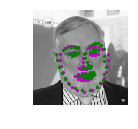

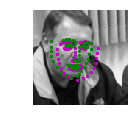

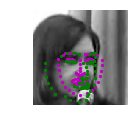

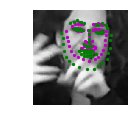

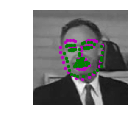

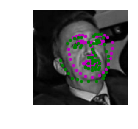

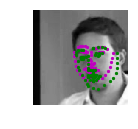

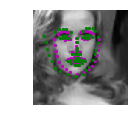

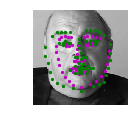

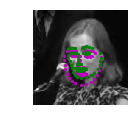

In [23]:
## visualize your test output

visualize_output(test_images, test_outputs, gt_pts)

In [24]:
## change the name to something uniqe for each new model
model_dir = 'saved_models/'
#model_name = 'keypoints_model_1.pt'
#model_name = 'keypoints_model_smoothL1Loss_epoc8.pt'
#model_name = 'keypoints_model_mseloss_epoc8.pt'
model_name = 'keypoints_model_smoothloss_2Dropout_epocn10.pt'


# save the model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

In [25]:
# Load the model
net.load_state_dict(torch.load(model_dir+model_name))
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc1_drop): Dropout(p=0.15)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc2_drop): Dropout(p=0.25)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
)

### Question 1: What optimization and loss functions did you choose and why?


**Answer**:  Adam optimizer with learning rate of 0.001 was applied, Adam are one of more sophasticated algorithm that can speed up the rate at which we could move down the plateau and then get off the plateau. 

Smooth L1 Loss was chosen, because in comparison to Smooth L1 Loss, MSE is used when numerical value features are not large, those high values in exploding gradient, the training loss did not converge well.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: The network consists of five convolution layers with different filters and kernel size. To avoid overfitting, two  dropout layers were added in between three fully-connected layers.

The initial network architecture was a five convolution layers, two fully-connected layers,  but without dropout. The initial network was trained from one epoch, the training loss was not good. Increasing the number of dense layers to three, and added dropout layers gradually, util two layers. 

In the final model, the loss per iteration looks smaller and smoother.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: Increasing the number of epochs by monitoring the losses with iterations, the model seemed fully converged, after 8 epochs.  To determine the batch size, I tried with batch_size to numbers more than 10. It looks like bigger batch size lead to slower training time, and it is harder to find optima.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, we can see how to extract a single filter (by index) from the first convolutional layer. The filter should appear as a grayscale grid.

[[-0.19705439 -0.24670722 -0.16951175 -0.08202022  0.13441323]
 [ 0.0245216   0.06693487  0.12770343 -0.21032324  0.1410535 ]
 [-0.00728262 -0.25066191  0.00332707  0.12386812 -0.16454005]
 [-0.18924616  0.10457864  0.03009903 -0.04433429  0.03639299]
 [-0.10581106 -0.15047534 -0.13587098  0.04695296 -0.09729864]]
(5, 5)


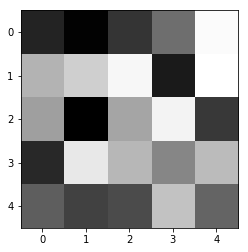

In [26]:
# Get the weights in the first conv layer, "conv1"

weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, we can characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

###  Filter an image to see the effect of a convolutional kernel
---

Text(0.5,1,'Kernel')

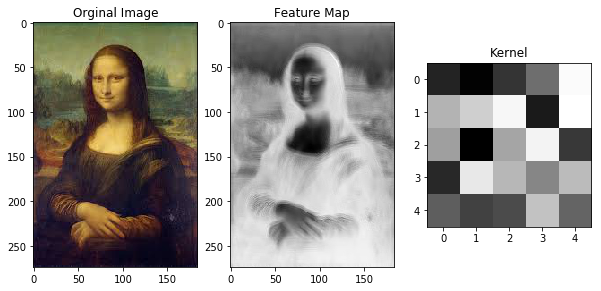

In [27]:
##load in and display any image from the transformed test dataset
import cv2

ori_img = cv2.imread('images/mona_lisa.jpg')
ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)

# convert to grayscale, normalize, rescale entries to lie in [0, 1]
gray_img = cv2.cvtColor(ori_img, cv2.COLOR_RGB2GRAY) / 255.0


## Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

filtered_image = cv2.filter2D(gray_img, -1, w[filter_index][0])

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 5))
ax1.imshow(ori_img, cmap='gray')
ax2.imshow(filtered_image, cmap='gray')
ax3.imshow(w[filter_index][0], cmap='gray')
ax1.set_title('Orginal Image')
ax2.set_title('Feature Map')
ax3.set_title('Kernel')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: It detects edges and colors of the image and shapes/contours of objects.  